<a href="https://colab.research.google.com/github/talmolab/sleap/blob/main/docs/notebooks/Analysis_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of EPM -animal

# Loading the data


In [1]:
filename = r"C:\Users\topohl\Documents\SLEAP\Projects\AnalysisEPM\animal\labels_EPM.004_GX010017.analysis.h5"

In [2]:
import h5py
import numpy as np

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()


===filename===
C:\Users\topohl\Documents\SLEAP\Projects\AnalysisEPM\animal\labels_EPM.004_GX010017.analysis.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(9257, 14, 2, 1)

===nodes===
0: Nose
1: left ear
2: right ear
3: left flank
4: right flank
5: tailbase
6: spine 1
7: left arm
8: right arm
9: center
10: spine 2
11: tail 1
12: tail 2
13: tail tip



Example of locations data shape of 9000, 14, 2, 1

- 9000: the number of frames;

- 14: the number of nodes in the skeleton;

- 2: for the x and y coordinates;

- 1: the number of distinct animal identities which were found.

Those counts of the matrix shape can be generated as follows:

In [3]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

frame count: 9257
node count: 14
instance count: 1


Data is loaded now.

## Fill missing values

In [4]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [5]:
locations = fill_missing(locations)

## Save x y coordinates to .csv file

In [19]:
tl_index = 0
tr_index = 1
br_index = 2
bl_index = 3
objL_index = 4
objR_index = 5

tl_loc = locations[:, tl_index, :, :]
tr_loc = locations[:, tr_index, :, :]
br_loc = locations[:, br_index, :, :]
bl_loc = locations[:, bl_index, :, :]
objL_loc = locations[:, objL_index, :, :]
objR_loc = locations[:, objR_index, :, :]

In [21]:
# Import the necessary libraries
import pandas as pd
import numpy as np

# create a list of body part names
geoms = ['tl', 'tr', 'br', 'bl', 'objL', 'objR']

# initialize the DataFrame
df = pd.DataFrame()

# loop through the body parts
for geom in geoms:
    x = eval(f"{geom}_loc[:, 0]") # retrieve the x coordinate
    y = eval(f"{geom}_loc[:, 1]") # retrieve the y coordinate
    x, y = x.ravel(), y.ravel() # unravel the arrays
    df[f"{geom}_x"] = x # add the x coordinate to the DataFrame
    df[f"{geom}_y"] = y # add the y coordinate to the DataFrame

# save the DataFrame as a csv file
df.to_csv("geom_locs.csv", index=False)


## Visualize body part movement across video

In [47]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [30]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

Text(0.5, 1.0, 'Bodypart tracks')

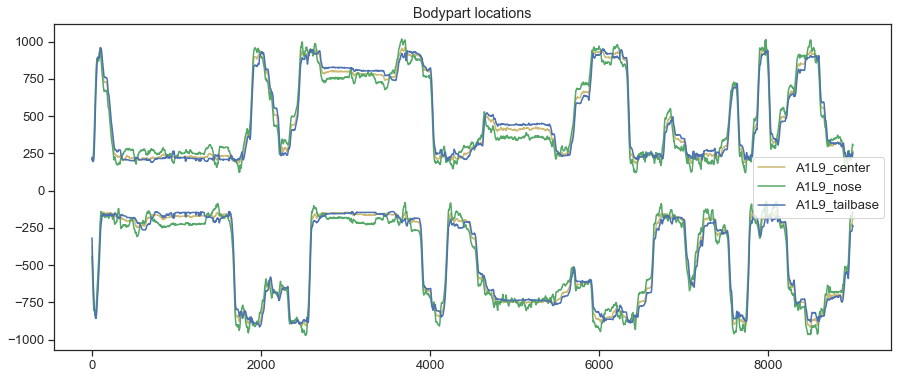

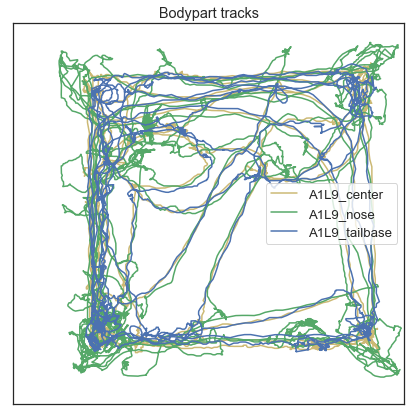

In [31]:
plt.figure()
plt.plot(center_loc[:,0,0], 'y',label='A1L9_center')
plt.plot(nose_loc[:,0,0], 'g',label='A1L9_nose')
plt.plot(tailbase_loc[:,0,0], 'b',label='A1L9_tailbase')


plt.plot(-1*center_loc[:,1,0], 'y')
plt.plot(-1*nose_loc[:,1,0], 'g')
plt.plot(-1*tailbase_loc[:,1,0], 'b')


plt.legend(loc="center right")
plt.title('Bodypart locations')


plt.figure(figsize=(7,7))
plt.plot(center_loc[:,0,0],center_loc[:,1,0], 'y',label='A1L9_center')
plt.plot(nose_loc[:,0,0],nose_loc[:,1,0], 'g',label='A1L9_nose')
plt.plot(tailbase_loc[:,0,0],tailbase_loc[:,1,0], 'b',label='A1L9_tailbase')
plt.legend()

plt.xlim(0,1024)
plt.xticks([])

plt.ylim(0,1024)
plt.yticks([])
plt.title('Bodypart tracks')

## More advanced visualizations

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

In [10]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

There are two flies. Let's get results for each separately.

In [11]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
center_vel_A1L9 = smooth_diff(center_loc[:, :, 0])

### Visualizing thorax x-y dynamics and velocity for fly 0

Text(0.5, 1.0, 'Velocity')

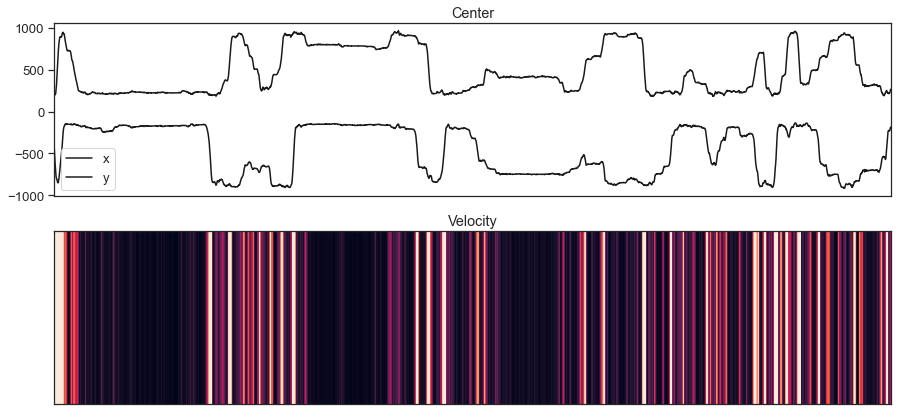

In [12]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(center_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*center_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Center')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(center_vel_A1L9[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

### Visualize thorax colored by magnitude of fly speed

Text(0.5, 1.0, 'Center tracks colored by magnitude of mouse speed')

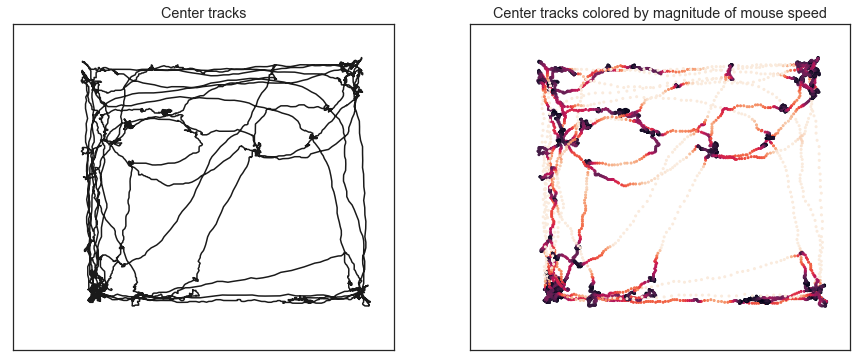

In [13]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(center_loc[:, 0, 0], center_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Center tracks')

kp = center_vel_A1L9  # use thx_vel_fly1 for other fly
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(center_loc[:,0,0], center_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Center tracks colored by magnitude of mouse speed')

### Find covariance in thorax velocities between fly-0 and fly-1

In [15]:
import pandas as pd

def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between
    
    win sets the number of frames over which the covariance is computed
    
    """
    
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    
    return np.array(s2.rolling(win).corr(s1))

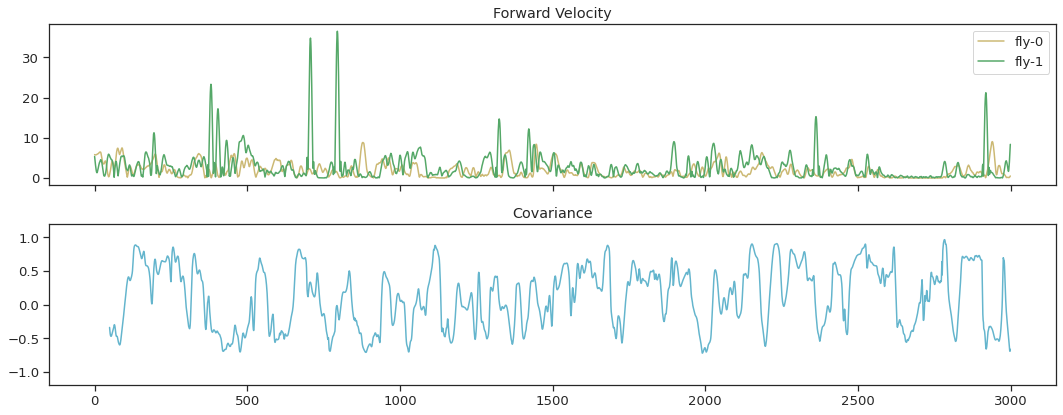

In [16]:
win = 50

cov_vel = corr_roll(thx_vel_fly0, thx_vel_fly1,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(thx_vel_fly0, 'y', label='fly-0')
ax[0].plot(thx_vel_fly1, 'g', label='fly-1')
ax[0].legend()
ax[0].set_title('Forward Velocity')

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

## Clustering

For an example of clustering the data, we'll

1. extract joint velocities for each joint,
2. run simple k-means on the velocities from each frame.


In [17]:
def instance_node_velocities(instance_idx):
    fly_node_locations = locations[:, :, :, instance_idx]
    fly_node_velocities = np.zeros((frame_count, node_count))

    for n in range(0, node_count):
        fly_node_velocities[:, n] = smooth_diff(fly_node_locations[:, n, :])
    
    return fly_node_velocities

In [18]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(node_count), node_names, rotation=20);
    plt.title(f'Fly {instance_idx} node velocities')

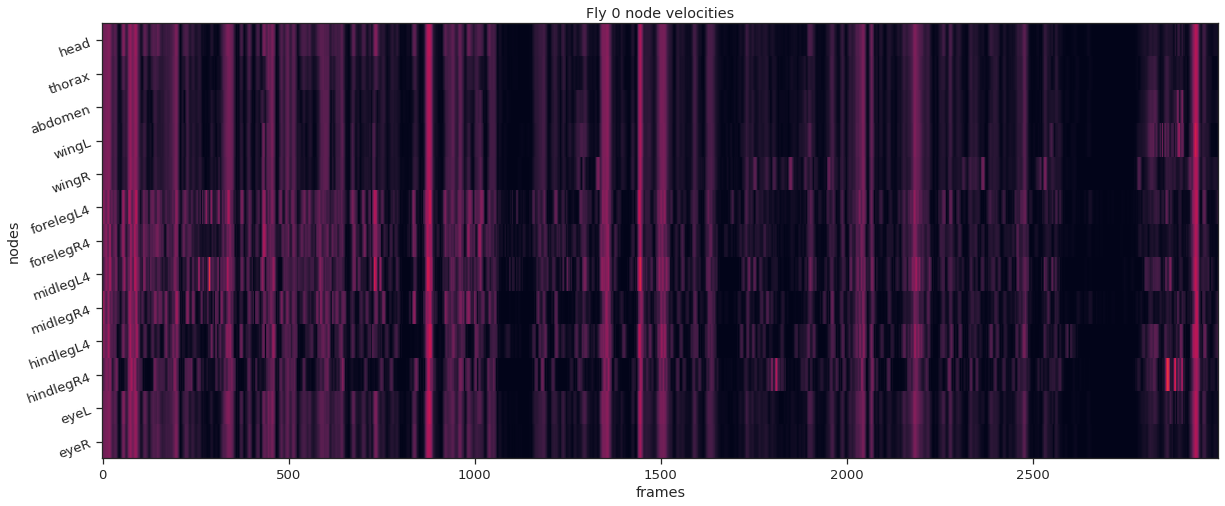

In [19]:
fly_ID = 0
fly_node_velocities = instance_node_velocities(fly_ID)
plot_instance_node_velocities(fly_ID, fly_node_velocities)

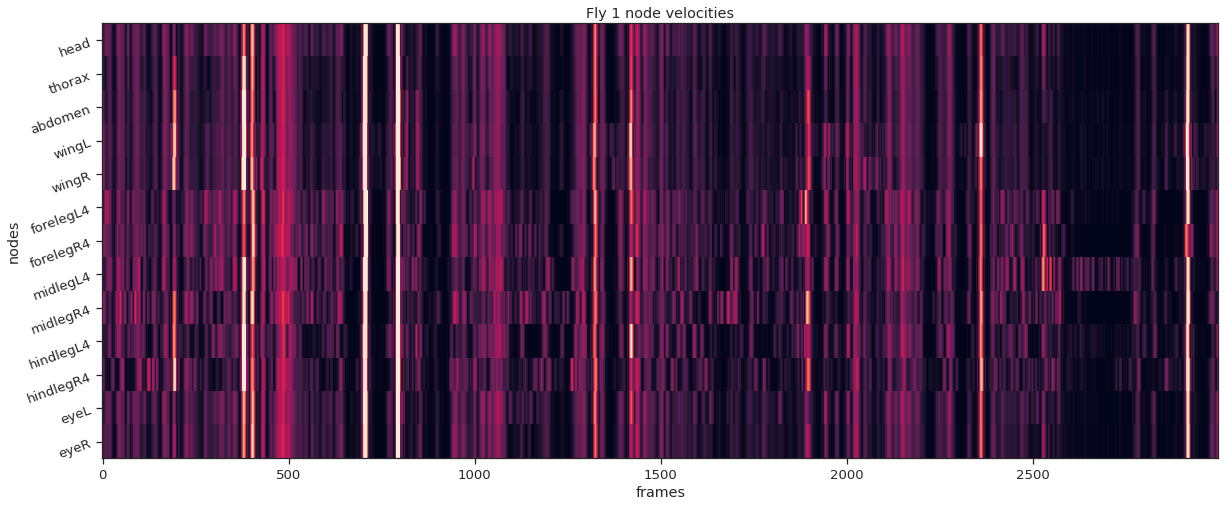

In [20]:
fly_ID = 1
fly_node_velocities = instance_node_velocities(fly_ID)
plot_instance_node_velocities(fly_ID, fly_node_velocities)

In [21]:
from sklearn.cluster import KMeans

In [22]:
nstates = 10

km = KMeans(n_clusters=nstates)

labels = km.fit_predict(fly_node_velocities)

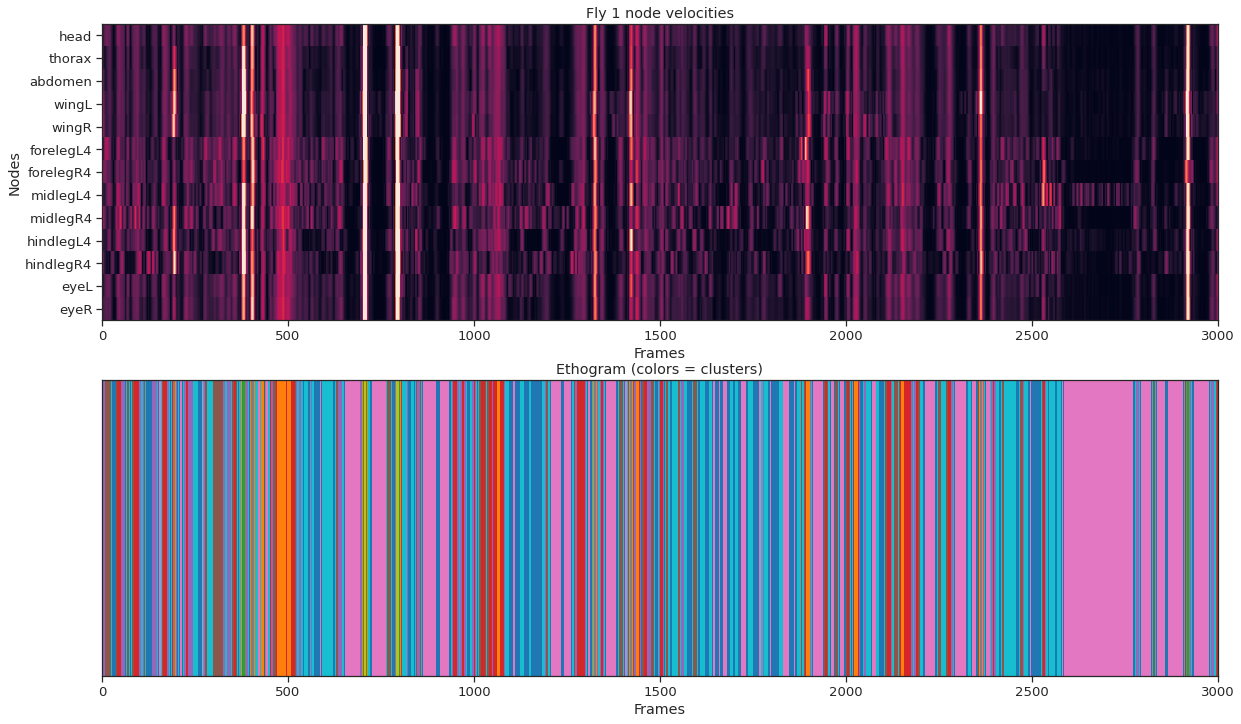

In [23]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(fly_node_velocities.T, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(node_count))
ax1.set_yticklabels(node_names);
ax1.set_title(f"Fly {fly_ID} node velocities")
ax1.set_xlim(0,frame_count)

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");